In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import urllib.request
from shapely.geometry import LineString
import math
import matplotlib

In [2]:
decp_mq = 'https://data.economie.gouv.fr/explore/dataset/decp_augmente/download/?format=csv&refine.libelleregionacheteur=Martinique&timezone=America/Santo_Domingo&lang=fr&use_labels_for_header=true&csv_separator=;'
urllib.request.urlretrieve(decp_mq, 'data/decp.csv')


('data/decp.csv', <http.client.HTTPMessage at 0x7fd2d4690490>)

In [3]:
df = pd.read_csv('data/decp.csv', sep=';')
# keep only works done for Martinique (format hell)
df = df.loc[((df.lieuExecutionCode == 'MQ') 
         | (df.lieuExecutionCode == 'Martinique') 
         | (df.lieuExecutionCode.str.startswith('972'))
         | (df.lieuExecutionNom.str.lower() == 'martinique')
         | (df.lieuExecutionNom == 'SMTVD')
         | ((df.lieuExecutionCode.isin(['2', '02']))
            & (df.lieuExecutionTypeCode.isin(['CODE DEPARTEMENT', 'CODE REGION']))))].copy()


In [4]:
dfs = df[['codeCommuneAcheteur', 'codeCommuneEtablissement', 'montantCalcule']].copy()
dfs['etablissement'] = np.where(dfs['codeCommuneEtablissement'] < 97000, 'FR', 
                                np.where(((dfs['codeCommuneEtablissement'].astype(str).str.startswith('971')) | (dfs['codeCommuneEtablissement'] == 97801)), 'GP',
                                         np.where(dfs['codeCommuneEtablissement'].astype(str).str.startswith('973'), 'GF',
                                             np.where(dfs['codeCommuneEtablissement'].astype(str).str.startswith('974'), 'RE',
                                                      dfs['codeCommuneEtablissement']))))
dfs.etablissement.unique()

array(['97209', '97213', '97232', '97207', '97222', '97227', '97218',
       '97210', '97231', 'GP', '97230', 'FR', '97223', '97221', '97229',
       'RE', '97217', '97215', '97233', '97228', '97224', '97205', 'GF',
       '97203', '97225', '97216', '97212', '97220', '97226', '97234',
       '97219', '97204', '97202', '97206', '97214'], dtype=object)

In [5]:
dfsg = (dfs[['codeCommuneAcheteur', 'etablissement', 'montantCalcule']]
.groupby(by=['codeCommuneAcheteur', 'etablissement'])
 .agg(total=('montantCalcule', 'sum'), nb=('montantCalcule', 'count'))).reset_index()
dfs_mq = dfsg.loc[dfsg.etablissement.str.startswith('972')].copy()
dfs_mq['etablissement'] = dfs_mq['etablissement'].astype(int)
dfs_mq.head(1)

,codeCommuneAcheteur,etablissement,total,nb
0,97202,97209,138720.0,1


In [6]:
MAIRIES_FILE = 'data/mairies-martinique.geojson'
COMMUNES_FILES = 'data/communes-martinique.geojson'

gdf_mq = gpd.read_file(COMMUNES_FILES)
gdf_mq['code'] = gdf_mq['code'].astype(int)
gdf_mq_mairie = gpd.read_file(MAIRIES_FILE)
gdf_mq_mairie['codgeo'] = gdf_mq_mairie['codgeo'].astype(int)

initial_crs = gdf_mq_mairie.geometry.crs.srs

gdf_mq = (gdf_mq.merge(dfs_mq.groupby('codeCommuneAcheteur').agg(buy=("total", "sum")).reset_index().rename(columns={"codeCommuneAcheteur":"code"})
                                     .merge(dfs_mq.groupby('etablissement').agg(sell=("total", "sum")).reset_index().rename(columns={"etablissement":"code"}), on="code", how="outer"),
                                     on='code', how='left')).fillna(0)
gdf_mq['balance'] = gdf_mq['sell'] - gdf_mq['buy']
gdf_mq.head(1)

,code,nom,geometry,buy,sell,balance
0,97201,Ajoupa-Bouillon,"POLYGON ((-61.14848 14.80590, -61.15340 14.805...",0.0,0.0,0.0


In [7]:
network = (dfs_mq
 .merge(gdf_mq_mairie, left_on='codeCommuneAcheteur', right_on='codgeo').rename(columns={'geometry': 'from'})
 .merge(gdf_mq_mairie, left_on='etablissement', right_on='codgeo').rename(columns={'geometry': 'to'})
)
network['geometry'] = network.apply(lambda row: LineString([row['from'], row['to']]), axis=1) #Create a linestring column
geo_network= gpd.GeoDataFrame(network, crs=initial_crs)

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


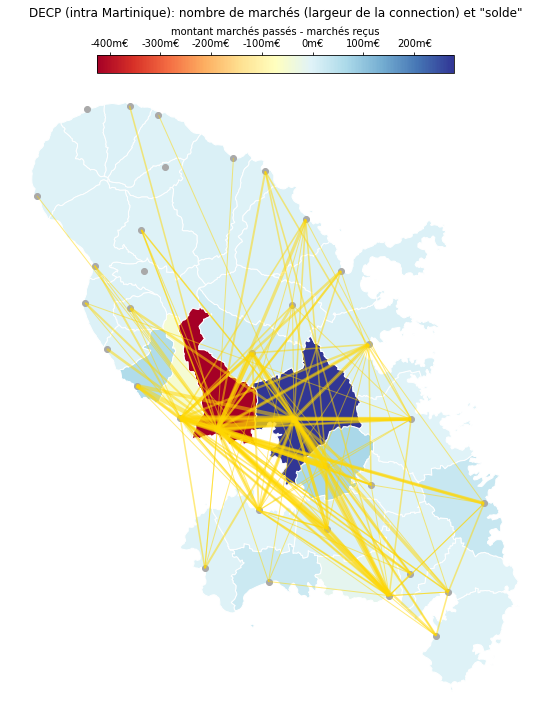

In [11]:
cmap = matplotlib.cm.RdYlBu

# adjust the colorbar format to show 
kfmt = lambda x, pos: f'{x/1000000:g}m€'
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle('DECP (intra Martinique): nombre de marchés (largeur de la connection) et "solde"')
ax = geo_network.plot(ax=ax, color="#ffd700", linewidth=np.log2(1 + geo_network['nb']), alpha=0.5)
gdf_mq.plot(ax=ax, column='balance', linewidth=1, edgecolor='white', legend=True, cmap=cmap, 
            legend_kwds={"pad": 0, "location":"top", "orientation":"horizontal", "label": "montant marchés passés - marchés reçus", "format": kfmt, "shrink":0.5}) #"title":"uuu"})
gdf_mq_mairie.plot(ax=ax, color="darkgrey")
_ = ax.axis("off")
fig.savefig('output/2022-11-06.png')